# Algorithm Implementation: Learning Classification without Disparate Mistreatment
__author__: Shaohuan Wu

__email__: sw3835@columbia.edu

The ProPublica COMPAS dataset uses a logistic regression algorithm to predict whether an offender will reoffend within two years, but it produces different misclassification rates for different social groups (e.g., black and white), which puts certain groups at a disadvantage.

This .ipynb file attempts to reproduce three constraints: false positive rate constraints, false negative rate constraints and both constraints. By rebuilding the logistic regression algorithm, we are committed to reducing the difference in the error classification rate of different sensitive features under the condition of guaranteeing the prediction accuracy, so as to ensure that the machine learning algorithm is more fair.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

Install required packages

In [2]:
!pip3 install --upgrade pip
!pip install setuptools==57.5.0
!pip3 install dccp
!pip install --upgrade cvxpy
import seaborn as sns
import traceback
import dccp
from copy import deepcopy
from sklearn import preprocessing
import cvxpy as cp
import sys

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
arviz 0.15.1 requires setuptools>=60.0.0, but you have setuptools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.5/819.5 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.5.0
    Uninstalling setuptools-57.5.0:
      Successfully uninstalled setuptools-57.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.3.2
    Uninstalling cvxpy-1.3.2:
      Successfully uninstalled cvxpy-1.3.2


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')
df.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

Data preprocessing

In [4]:
data = df[["age_cat", "race", "sex", "priors_count", "c_charge_degree",'two_year_recid']]
data.head()
data.isna().sum().sum()

0

In [5]:
data = data[(data['race']=='African-American')|(data['race']=='Caucasian')].reset_index(drop=True)
data.loc[data['race'] == 'African-American', 'race'] = 1
data.loc[data['race'] == 'Caucasian', 'race'] = 0
data.loc[data['sex'] == 'Male', 'sex'] = 1
data.loc[data['sex'] == 'Female', 'sex'] = 0
data.loc[data['c_charge_degree'] == 'F', 'c_charge_degree'] = 1
data.loc[data['c_charge_degree'] == 'M', 'c_charge_degree'] = 0
data.loc[data['two_year_recid'] == 0, 'two_year_recid'] = -1
data = pd.get_dummies(data['age_cat']).join(data).drop(['age_cat'], axis=1)
data = data.astype('int')
data.head()

,25 - 45,Greater than 45,Less than 25,race,sex,priors_count,c_charge_degree,two_year_recid
0,1,0,0,1,1,0,1,1
1,0,0,1,1,1,4,1,1
2,0,0,1,1,1,1,1,-1
3,1,0,0,0,1,14,1,1
4,1,0,0,0,0,0,0,-1


Create original logistic regression model

In [6]:
# Split the data set into a training set and a test set
X = data.drop('two_year_recid', axis=1)
y = data['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=1899)

# Create and train original logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)

# Evaluate model performance
acc = accuracy_score(y_test, y_pred)
print("original accuracy:", acc)

original accuracy: 0.6695934959349593


Create dataframe to calculate original DFPR and DFNR values

In [7]:
df_y_test=pd.DataFrame(y_test)
df_y_test.columns=['y_test']
df_y_test['y_pred']=y_pred
df_y_test['race']=X_test['race']

In [8]:
df_y_test

,y_test,y_pred,race
6061,-1,-1,1
2368,-1,1,1
1353,-1,1,0
1517,-1,-1,0
4221,-1,-1,1
...,...,...,...
1735,-1,1,0
171,-1,-1,1
1732,1,1,0
4924,-1,-1,0


In [9]:
def test_fairness(df):
  race_black_pr=df.loc[(df['race']==1) & (df['y_test']==-1)]
  race_white_pr=df.loc[(df['race']==0) & (df['y_test']==-1)]
  race_black_nr=df.loc[(df['race']==1) & (df['y_test']==1)]
  race_white_nr=df.loc[(df['race']==0) & (df['y_test']==1)]

  DFPR=sum(race_black_pr['y_test']!=race_black_pr['y_pred'])/race_black_pr.shape[0]-sum(race_white_pr['y_test']!=race_white_pr['y_pred'])/race_white_pr.shape[0]
  DFNR=sum(race_black_nr['y_test']!=race_black_nr['y_pred'])/race_black_nr.shape[0]-sum(race_white_nr['y_test']!=race_white_nr['y_pred'])/race_white_nr.shape[0]

  return DFPR, DFNR

rate = test_fairness(df_y_test)

In [10]:
rate

(0.20732382187635104, -0.334694824474718)

Split the data set according to sensitive features and add intercept items

In [11]:
N = X_train.shape[0]
N1 = X_train[X_train['race']==1].shape[0]
N0 = N - N1

X_train_N1 = X_train[X_train['race']==1].to_numpy()
X_train_N0 = X_train[X_train['race']==0].to_numpy()
y_train_N1 = y_train[X_train['race']==1].to_numpy()
y_train_N0 = y_train[X_train['race']==0].to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

intercept_column1 = np.ones((X_train_N1.shape[0], 1))
intercept_column0 = np.ones((X_train_N0.shape[0], 1))
X_train_N1 = np.hstack((intercept_column1,X_train_N1))
X_train_N0 = np.hstack((intercept_column0,X_train_N0))
intercept_column = np.ones((X_train.shape[0], 1))
X_train = np.hstack((intercept_column,X_train))

**Method 1: constraints on false postive rate**


first calculated g(y,X), then get constraints and train the new model_1

In [12]:
def g(X, y, theta):
  dis = X*theta
  return cp.minimum(0,cp.multiply((1-y)/2, cp.multiply(y,dis)))

In [13]:
def get_constraints_1(X, y, X_N0, y_N0, X_N1, y_N1):

  max_iters = 100
  max_iter_dccp = 50
  c=0
  eps = 1e-6

  num_points, num_features = X.shape
  theta_hat = cp.Variable(num_features)

  np.random.seed(1899)
  theta_hat.value = np.random.rand(X.shape[1])

  loss = cp.sum(cp.logistic(cp.multiply(-y, X*theta_hat)))/ num_points

  cons1 = cp.sum(g(X_N0, y_N0, theta_hat))*((N1/N)/sum(y_N0 == -1))
  cons2 = cp.sum(g(X_N1, y_N1, theta_hat))*((N0/N)/sum(y_N1 == -1))

  thresh = 0
  constraints1 = (cons1 <= cons2  + thresh )
  constraints2 = (cons1 >= cons2  - thresh )

  p = cp.Problem(cp.Minimize(loss), [])
  p.solve()

  prob = cp.Problem(cp.Minimize(loss), [constraints1,constraints2])


  try:
    tau, mu = 5.0, 1.2

    prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
        solver=cp.ECOS, verbose=False,
        feastol=eps, abstol=eps, reltol=eps,feastol_inacc=eps, abstol_inacc=eps, reltol_inacc=eps,
        max_iters=max_iters, max_iter=max_iter_dccp)

    assert prob.status in ["Converged", "optimal"]

  except Exception as e:
    print(f"An error occurred: {e}")
    raise

  theta_hat = np.array(theta_hat.value).flatten()

  return theta_hat

In [14]:
theta_1=get_constraints_1(X_train, y_train, X_train_N0,
                     y_train_N0, X_train_N1 ,y_train_N1)

/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  if not (self.is_constant() or other.is_constant()):
/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  if not (self.is_constant() or other.is

In [15]:
def change_model(model, theta_new):
  model.coef_=theta_new.reshape(-1,1)[1:8].T
  model.intercept_ = theta_new.reshape(-1,1)[0]
  return model

model_1 = change_model(logreg, theta_1)


def train_new_model(model, X_test, y_test):
  y_pred_new=model.predict(X_test)
  acc = accuracy_score(y_test, y_pred_new) # Accuracy
  return y_pred_new, acc

y_pred_1, acc_1 = train_new_model(model_1, X_test, y_test) # new prediction and new accuracy

df_y_test['y_pred']=y_pred_1
df_y_test
rate_1 = test_fairness(df_y_test) # new dfpr and dfnr

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [16]:
acc_1, rate_1

(0.6679674796747967, (0.09285776048421962, -0.21556249065880262))

**Method 2: constraints on false negative rate**


first calculated g_2(y,X), then get constraints and train the new model_2

In [17]:
def g2(X, y, theta):
  dis = X*theta
  return cp.minimum(0,cp.multiply((1+y)/2, cp.multiply(y,dis)))

In [18]:
def get_constraints_2(X, y, X_N0, y_N0, X_N1, y_N1):

  max_iters = 100
  max_iter_dccp = 50
  c=0
  eps = 1e-6

  num_points, num_features = X.shape
  theta_hat = cp.Variable(num_features)

  np.random.seed(1899)
  theta_hat.value = np.random.rand(X.shape[1])

  loss = cp.sum(cp.logistic(cp.multiply(-y, X*theta_hat)))/ num_points

  cons1 = cp.sum(g2(X_N0, y_N0, theta_hat))*((N1/N)/sum(y_N0 == -1))
  cons2 = cp.sum(g2(X_N1, y_N1, theta_hat))*((N0/N)/sum(y_N1 == -1))

  thresh = 0
  constraints1 = (cons1 <= cons2  + thresh )
  constraints2 = (cons1 >= cons2  - thresh )

  p = cp.Problem(cp.Minimize(loss), [])
  p.solve()

  prob = cp.Problem(cp.Minimize(loss), [constraints1,constraints2])


  try:
    tau, mu = 5.0, 1.2

    prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
        solver=cp.ECOS, verbose=False,
        feastol=eps, abstol=eps, reltol=eps,feastol_inacc=eps, abstol_inacc=eps, reltol_inacc=eps,
        max_iters=max_iters, max_iter=max_iter_dccp)

    assert prob.status in ["Converged", "optimal"]

  except Exception as e:
    print(f"An error occurred: {e}")
    raise

  theta_hat = np.array(theta_hat.value).flatten()

  return theta_hat

In [19]:
theta_2=get_constraints_2(X_train, y_train, X_train_N0,
                     y_train_N0, X_train_N1 ,y_train_N1)

/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  if not (self.is_constant() or other.is_constant()):
/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 5 times so far.

  if not (self.is_constant() or other.is

In [20]:
model_2 = change_model(logreg, theta_2)

In [21]:
y_pred_2, acc_2 = train_new_model(model_2, X_test, y_test) # new prediction and new accuracy

df_y_test['y_pred']=y_pred_2
df_y_test
rate_2 = test_fairness(df_y_test) # new DFPR and DFNR

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [22]:
acc_2, rate_2

(0.6663414634146342, (0.016511024643320382, -0.09115447161725959))

**Method 3: constraints on both false postive rate and false negative rate**


this model need use both g(y,X) and g_2(y,X), then get constraints and train the new model_3

In [23]:
def get_constraints_3(X, y, X_N0, y_N0, X_N1, y_N1):

  max_iters = 100
  max_iter_dccp = 50
  c=0
  eps = 1e-6

  num_points, num_features = X.shape
  theta_hat = cp.Variable(num_features)

  np.random.seed(1899)
  theta_hat.value = np.random.rand(X.shape[1])

  loss = cp.sum(cp.logistic(cp.multiply(-y, X*theta_hat)))/ num_points

  cons1 = cp.sum(g(X_N0, y_N0, theta_hat))*((N1/N)/sum(y_N0 == -1))
  cons2 = cp.sum(g(X_N1, y_N1, theta_hat))*((N0/N)/sum(y_N1 == -1))
  cons3 = cp.sum(g2(X_N0, y_N0, theta_hat))*((N1/N)/sum(y_N0 == -1))
  cons4 = cp.sum(g2(X_N1, y_N1, theta_hat))*((N0/N)/sum(y_N1 == -1))

  thresh = 0
  constraints1 = (cons1 <= cons2  + thresh )
  constraints2 = (cons1 >= cons2  - thresh )
  constraints3 = (cons3 <= cons4  + thresh )
  constraints4 = (cons3 >= cons4  - thresh )

  p = cp.Problem(cp.Minimize(loss), [])
  p.solve()

  prob = cp.Problem(cp.Minimize(loss), [constraints1,constraints2, constraints3,constraints4])


  try:
    tau, mu = 5.0, 1.2

    prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
        solver=cp.ECOS, verbose=False,
        feastol=eps, abstol=eps, reltol=eps,feastol_inacc=eps, abstol_inacc=eps, reltol_inacc=eps,
        max_iters=max_iters, max_iter=max_iter_dccp)

    assert prob.status in ["Converged", "optimal"]

  except Exception as e:
    print(f"An error occurred: {e}")
    raise

  theta_hat = np.array(theta_hat.value).flatten()

  return theta_hat

In [24]:
theta_3=get_constraints_3(X_train, y_train, X_train_N0,
                     y_train_N0, X_train_N1 ,y_train_N1)

/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 7 times so far.

  if not (self.is_constant() or other.is_constant()):
/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 8 times so far.

  if not (self.is_constant() or other.is

In [25]:
model_3 = change_model(logreg, theta_3)

In [26]:
y_pred_3, acc_3 = train_new_model(model_3, X_test, y_test) # new prediction and new accuracy

df_y_test['y_pred']=y_pred_3
df_y_test
rate_3 = test_fairness(df_y_test) # new DFPR and DFNR

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


**Compare the original model and these three models(accuracy, DFPR, DFNR)**

In [27]:
acc, rate

(0.6695934959349593, (0.20732382187635104, -0.334694824474718))

In [28]:
acc_1, rate_1

(0.6679674796747967, (0.09285776048421962, -0.21556249065880262))

In [29]:
acc_2, rate_2

(0.6663414634146342, (0.016511024643320382, -0.09115447161725959))

In [30]:
acc_3, rate_3

(0.6634146341463415, (0.07694336359706008, -0.09957995284228938))

In [31]:
acc_col = [acc, acc_1, acc_2, acc_3]
DFPR_col = [rate[0], rate_1[0], rate_2[0], rate_3[0]]
DFNR_col = [rate[1], rate_1[1], rate_2[1], rate_3[1]]

Show all models accuracy and fairness performance

In [32]:
outcome = pd.DataFrame({'Accuracy': acc_col, 'DFPR': DFPR_col, 'DFNR': DFNR_col})
rows_name = ['original model', 'method_1', 'method_2', 'method_3']
outcome.index = rows_name
outcome

,Accuracy,DFPR,DFNR
original model,0.669593,0.207324,-0.334695
method_1,0.667967,0.092858,-0.215562
method_2,0.666341,0.016511,-0.091154
method_3,0.663415,0.076943,-0.099580


From the above dataframe, we can see that all three constraint methods can reduce the difference in the error classification rate of different sensitive features under the condition of guaranteeing the prediction accuracy.

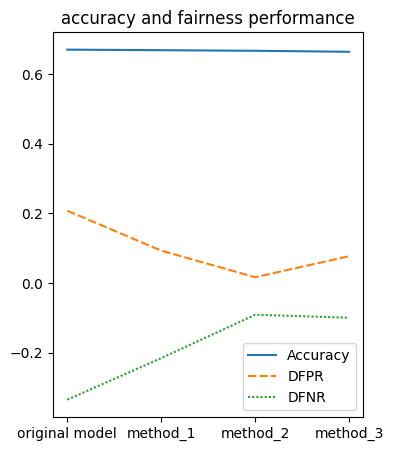

In [41]:
plt.figure(figsize=(4, 5))
sns.lineplot(data=outcome)
plt.title('accuracy and fairness performance')
plt.show()